# Fourier Neural Operators

In this session, we are going to look into the implementation of Fourier Neural Operators (FNO). As usual, let us first import all the necessary libraries.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')

# print pytorch version and cuda version
print(torch.__version__, device)

2.1.1+cu118 cuda


### Fourier Transform

The *Fourier Transform* is a powerful mathematical tool used to analyze signals and functions. It allows us to break down a complex signal (such as a sound wave or an image) into its basic building blocks: simple sinusoidal waves. Think of it as translating a signal from the *time domain* (how it changes over time) to the *frequency domain* (how much of each frequency is present in the signal). This is incredibly useful for tasks like signal processing, image analysis, and even solving differential equations.

More formally, for a continuous signal $f(t)$, the Fourier Transform is defined as:

$F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i \omega t} \, dt$

- $f(t)$: The original signal in the time domain.
- $F(\omega)$: The transformed signal in the frequency domain.
- $\omega$: The angular frequency.
- $e^{-i \omega t} = \cos(\omega t) - i\sin(\omega t)$: A complex exponential (Euler's formula) that serves as the basis function.

Consequently, the inverse *Fourier Transform*, which converts back from the frequency domain to the time domain, is given by:

$f(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} F(\omega) e^{i \omega t} \, d\omega$.

### Discrete Fourier Transform (DFT) and Fast Fourier Transform (FFT)

In practice, most signals are discrete rather than continuous, so we use the *Discrete Fourier Transform (DFT)*:

$X_k = \sum_{n=0}^{N-1} x_n e^{-i \frac{2\pi}{N} kn}$

where:
- $x_n$: The input signal of length $N$.
- $X_k$: The frequency component at index $k$.
- $k$: The frequency index.


However, the DFT can be computationally expensive because, as in the formula, we will need to compute $N$ multiplications and additions *for every frequency component*. If there were $N$ frequency components, it would been that the computational complexity would be $O(N^2)$ which can be devastating for real-time applications or when $N$ is large.

That’s where the *Fast Fourier Transform (FFT)* comes in. The FFT is an optimized algorithm for computing the DFT much faster by exploiting symmetries in the DFT, reducing the computational complexity from $O(N^2)$ to $O(n \log n)$. For example, for $N = 1024$, DFT requires $1,048,576$ operations, while FFT needs only $10,240$. This speedup makes it feasible to work with large signals in real-time applications like audio processing, communications, and data compression.

For more about FFT, see [this book](https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.03-Fast-Fourier-Transform.html).

### FFT in PyTorch

Now that we brushed up on the basics of Fourier Transform, DFT, and FFT, let us see how we could implement it in PyTorch. First, we generate a signal by combining two sine waves with wave lengths of 1/15 and 1/20 radians, respectively (or equivalently, frequencies of 15Hz and 20Hz):

$x(t) = \sin(\frac{2\pi x}{1/15}) + \sin(\frac{2\pi y}{1/20}) = \sin(30\pi) + \sin(40\pi)$.

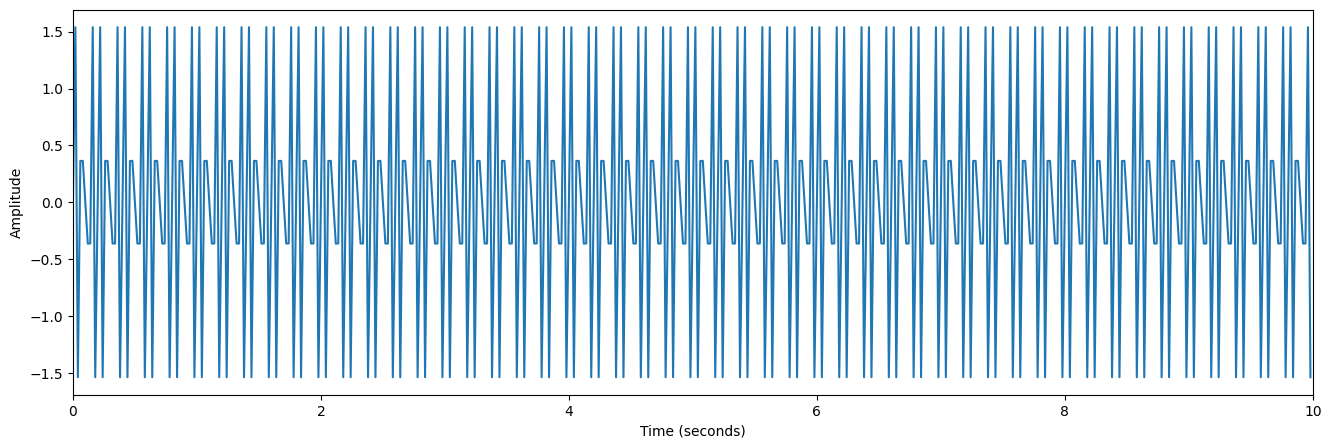

In [10]:
Ts = 1/50               # time step
t = np.arange(0,10,Ts)  # 10 seconds
x = np.sin(2*np.pi*15*t) + np.sin(2*np.pi*20*t)
plt.figure(figsize=(16,5))
plt.plot(t, x)
plt.xlim([0,10])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

Now, the good news is, PyTorch already comes with an implementation of FFT. So you don't need to implement it on your own (although it is not terribly difficult to do, if you want to get your hands dirty). Below is how you could perform FFT in PyTorch:

Text(0, 0.5, 'Magnitude')

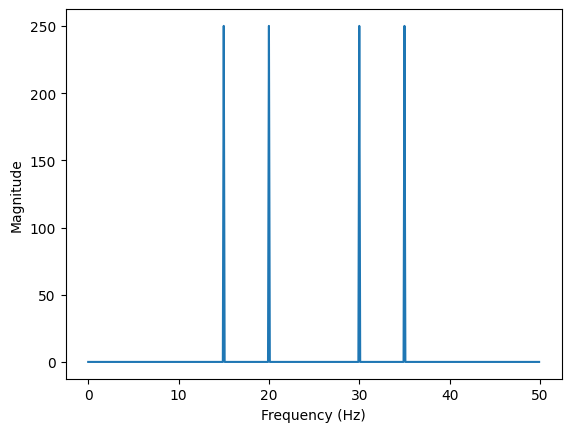

In [11]:
x_ft = torch.fft.fft(torch.tensor(x))
fs = 1/Ts
f = np.arange(len(x_ft))*fs/len(x_ft)  # frequency range
plt.plot(f, np.abs(x_ft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

One weird thing you may have noticed is that the plot actually shows four frequency peaks, even though the signal we know has two frequencies at 15 Hz and 20 Hz. Here, the second half of the plot is actually the mirror reflection (comlex conjugates) of the first half. So the 30 Hz and 35 Hz components in the plot actually correspond to their mirror images -20 Hz and -15 Hz respectively.

Hence, to better visualize considering this periodicity, you can use the `torch.fft.fftshift` function, which performs a circular shift on the transform.

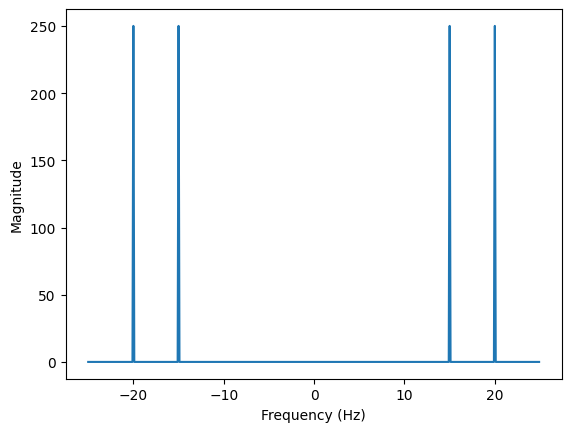

In [12]:
n = len(x)
f_shift = np.arange(-n/2,n/2)*(fs/n)    # shifted frequency range
x_ft_shift = torch.fft.fftshift(x_ft)   # circular shift of the Fourier transform result
plt.plot(f_shift, np.abs(x_ft_shift))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

Like what we just saw, Fourier Transform performed on real-valued signals will always return symmetric mirror images (complex conjugates) of the frequency components, which may be redundant. If you want to avoid this redundant representation, you could use the `torch.fft.rfft` function (notice the letter 'r' denoting 'real-valued') instead.

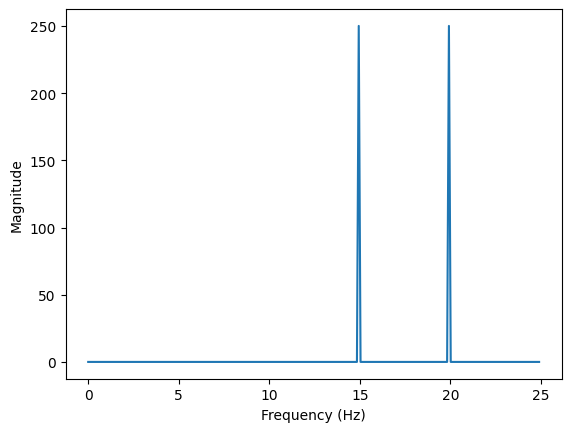

In [13]:
x_rft = torch.fft.rfft(torch.tensor(x))
fs = 1/Ts
f = np.arange(len(x_rft))*fs/len(x_rft)/2  # we only need the half of the frequency range now
plt.plot(f, np.abs(x_rft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

The inverse transform of `fft` and `rfft` are given as `ifft` and `irfft`, respectively (notice the letter 'i' that stands for 'inverse').

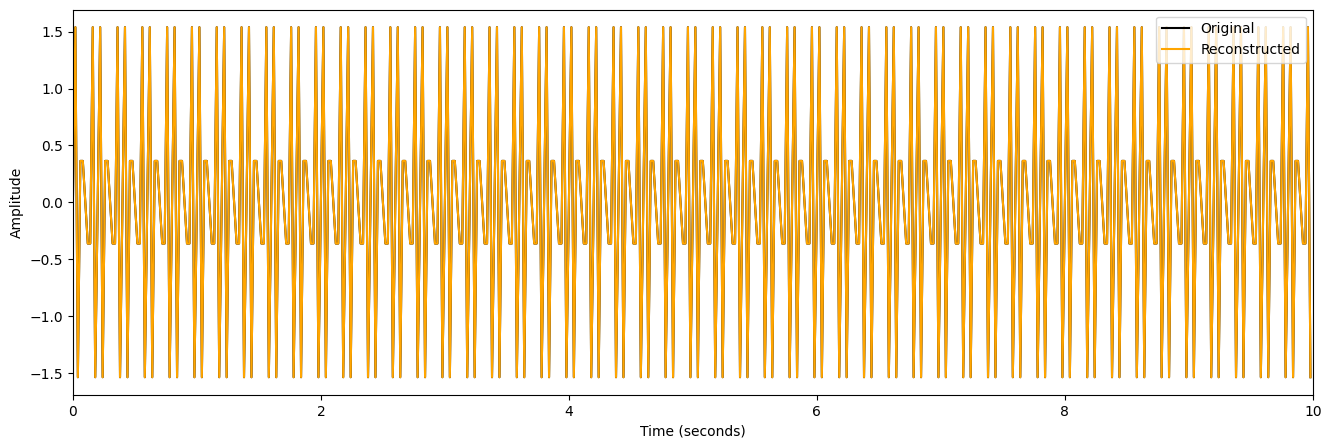

In [21]:
x_recon = torch.fft.ifft(x_ft)   # inverse of the regular transform 
plt.figure(figsize=(16,5))
plt.plot(t, x, c='black', label='Original')
plt.plot(t, x_recon.numpy(), c='orange', label='Reconstructed')
plt.xlim([0,10])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

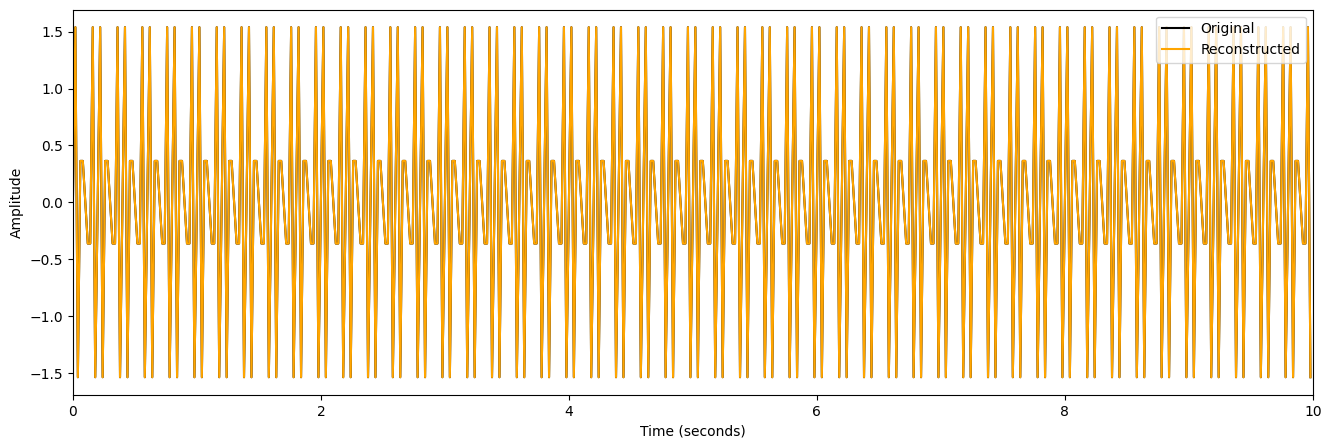

In [22]:
x_r_recon = torch.fft.irfft(x_rft)   # inverse of the real-valued transform 
plt.figure(figsize=(16,5))
plt.plot(t, x, c='black', label='Original')
plt.plot(t, x_r_recon.numpy(), c='orange', label='Reconstructed')
plt.xlim([0,10])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Finally, one of the common uses of Fourier transform is for the compression of signal. Since we can now decompose a function into different frequency components, we can compress the data size of a signal by discarding insignificant, mostly noisy high-frequency components and keeping only low-frequency components. This is, in fact, a very popular way of compressing digital audio and image data, such as in JPEG and MP3.

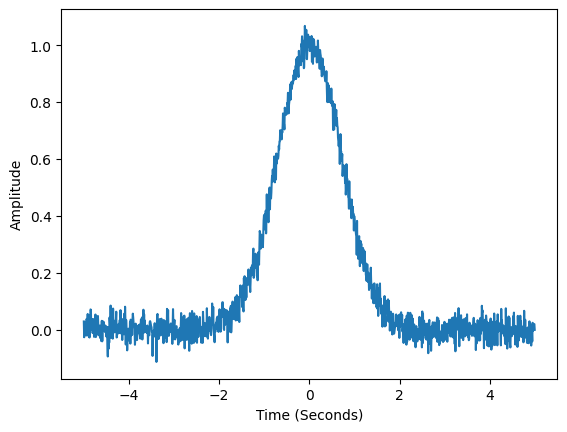

In [30]:
Ts = 1./128                 # sampling rate 128 Hz
t = np.arange(-5,5,Ts)
x = np.exp(-t**2) + 0.03*np.random.randn(len(t))           # bell curve with noise

plt.plot(t, x)
plt.xlabel('Time (Seconds)')
plt.ylabel('Amplitude')
plt.show()

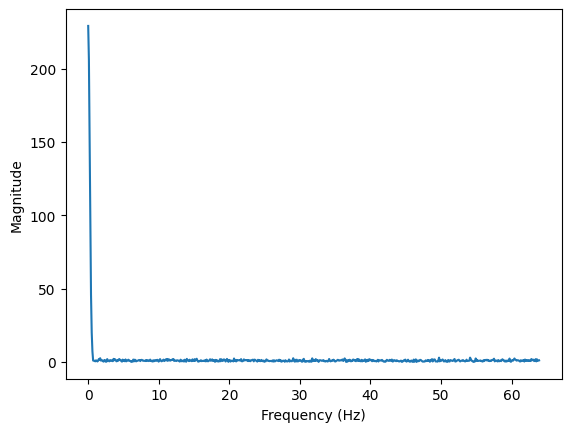

In [31]:
x_rft = torch.fft.rfft(torch.tensor(x))
fs = 1/Ts
f = np.arange(len(x_rft))*fs/len(x_rft)/2  # we only need the half of the frequency range now
plt.plot(f, np.abs(x_rft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

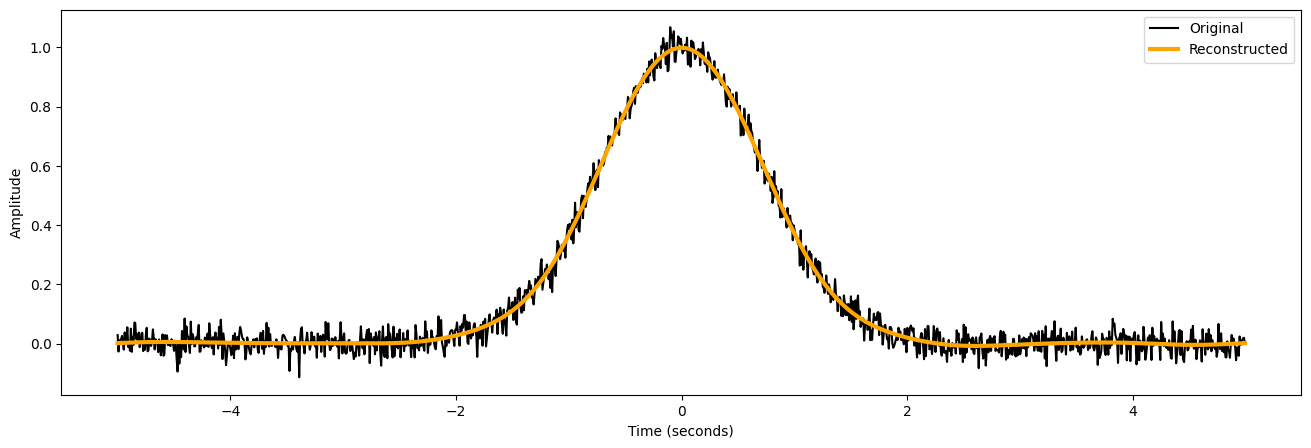

In [40]:
down_sampled = x_rft[:10]        # take the first 10 lowest frequency components and discard the rest

temp = torch.zeros_like(x_rft)   # to reconstruct the signal we need the same number of elements as the original signal
temp[:10] = down_sampled
x_r_recon = torch.fft.irfft(temp)
plt.figure(figsize=(16,5))
plt.plot(t, x, c='black', label='Original')
plt.plot(t, x_r_recon.numpy(), c='orange', label='Reconstructed', linewidth=3)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Spectral Convolution

Fast Fourier transform we just saw above plays a critical role in neural operators as the means to perform neural network inference in the continuous function space (as opposed to discrete vector space). Below, we define the `SpectralConv1d` layer, which first maps a 1D signal to the frequency space via the Fourier transform, multiplies weights (as in typical neural nets), and pulls the neural net outputs back to the original space. This new layer will come handy in our implementation of the Fourier Neural Operator (FNO).

In [41]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, n_freqs):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_freqs = n_freqs  # Number of Fourier frequencies to be kept

        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.n_freqs, dtype=torch.cfloat))


    def forward(self, x):
        # Fourier Transform
        x_ft = torch.fft.rfft(x) # [batch, channels, signal_length] -> [batch, channels, signal_length//2 + 1]
        
        # Weighted sum (neural network operation)
        out_ft = torch.zeros(x.shape[0], self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.n_freqs] = torch.einsum("bix,iox->box", x_ft[:, :, :self.n_freqs], self.weights)

        # Inverse Fourier Transform
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

### Fourier Neural Operator (FNO)
Now, here's the implementation of FNO.

In [ ]:
class FNO1d(nn.Module):
    def __init__(self, width):
        super(FNO1d, self).__init__()
        self.width = width
        self.fc0 = nn.Linear(2, self.width) # 2 inputs: (x, a(x))

        self.conv0 = SpectralConv1d(self.width, self.width, 16)
        self.conv1 = SpectralConv1d(self.width, self.width, 16)
        self.conv2 = SpectralConv1d(self.width, self.width, 16)
        self.conv3 = SpectralConv1d(self.width, self.width, 16)

        self.skip0 = nn.Conv1d(self.width, self.width, 1)
        self.skip1 = nn.Conv1d(self.width, self.width, 1)
        self.skip2 = nn.Conv1d(self.width, self.width, 1)
        self.skip3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)  # output: u(x)

    def forward(self, x):
        # Step 1: map to a larger dimensional feature space
        x = self.fc0(x)         # [Batch, Nx, C] -> [Batch, Nx, Width]
        x = x.permute(0, 2, 1)  # [Batch, C, Nx]

        # Step 2: Integral operators u' = (W + K)(u).
        x = self.skip0(x) + self.conv0(x)
        x = nn.SiLU()(x)

        x = self.skip1(x) + self.conv1(x)
        x = nn.SiLU()(x)

        x = self.skip2(x) + self.conv2(x)
        x = nn.SiLU()(x)

        x = self.skip3(x) + self.conv3(x)
        x = nn.SiLU()(x)

        # Step 3: project from feature space to output space
        x = x.permute(0, 2, 1)  # [Batch, Nx, C]
        x = self.fc1(x)         # [Batch, Nx, C] -> [Batch, Nx, Width]
        x = F.relu(x)
        x = self.fc2(x)         # [Batch, Nx, C] -> [Batch, Nx, 1]
        
        # since there are only one output
        x = x.squeeze(-1)       # [Batch, Nx, 1] -> [Batch, Nx]
        
        return x

### Application - 1D Burger's Equation

Burger's equation is a fundamental partial differential equation in applied mathematics and physics, often used to model various phenomena such as fluid dynamics, gas dynamics, traffic flow, and acoustics. It combines elements of nonlinear advection and diffusion, making it a simplified model for understanding shock wave formation and viscous effects. The equation is particularly notable for its role as a prototype in studying nonlinear systems and turbulence, and it serves as a stepping stone for more complex equations like the Navier-Stokes equations. The equation is written as:

$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$,

where
- $u(x,t)$ is the unknown function representing velocity or other conserved quantities
- $\nu$ is the viscosity (a positive constant)
- $\frac{\partial u}{\partial t}$ represents the time evolution
- $u\frac{\partial u}{\partial x}$ captures the nonlinear advection
- $\frac{\partial^2 u}{\partial x^2}$ accounts for the diffusive effects

In [42]:
raw_data = np.load('data/1D_Burger.npz')
A = raw_data['a']
U = raw_data['u']

N, L = A.shape

# 1D grid
X = np.tile(np.linspace(0, 1, L), (N,1))

In [17]:
downsample_rate = 32

A_sampled = A[:, ::downsample_rate]
U_sampled = U[:, ::downsample_rate]
X_sampled = X[:, ::downsample_rate]

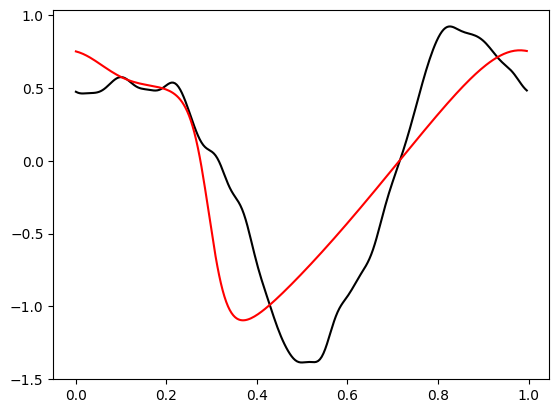

In [18]:
i = 1
plt.plot(X_sampled[i,:], A_sampled[i,:], color='black')
plt.plot(X_sampled[i,:], U_sampled[i,:], color='red')

In [19]:
A_sampled = np.expand_dims(A_sampled, -1)
X_sampled = np.expand_dims(X_sampled, -1)
U_sampled = np.expand_dims(U_sampled, -1)

data = torch.cat([torch.Tensor(X_sampled), torch.Tensor(A_sampled), torch.Tensor(U_sampled)], dim=2)
data.shape

torch.Size([2048, 256, 3])

In [20]:
N_train = int(0.7*N)
N_val = int(0.15*N)
N_test = int(0.15*N)

train_data, val_data, test_data = data[:N_train, :, :], data[N_train:N_train+N_val, :, :], data[-N_test:, :, :]

train_data.shape, val_data.shape, test_data.shape

(torch.Size([1433, 256, 3]),
 torch.Size([307, 256, 3]),
 torch.Size([307, 256, 3]))

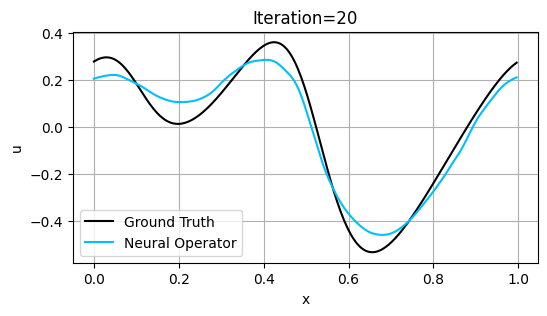

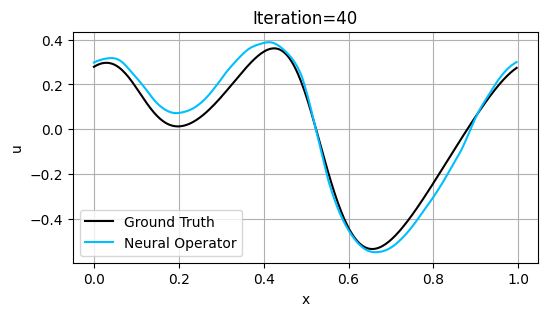

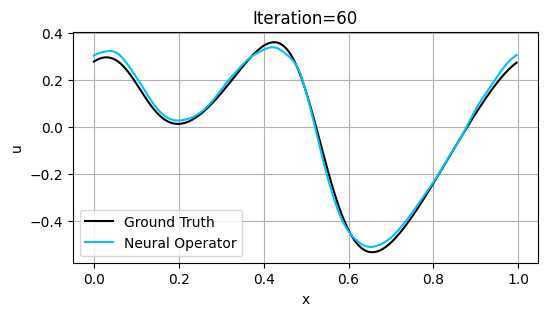

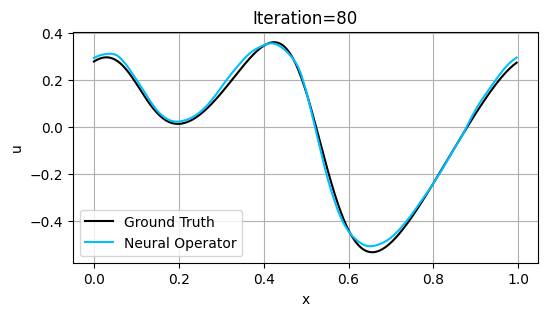

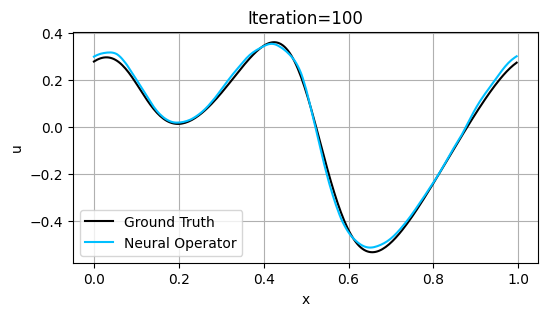

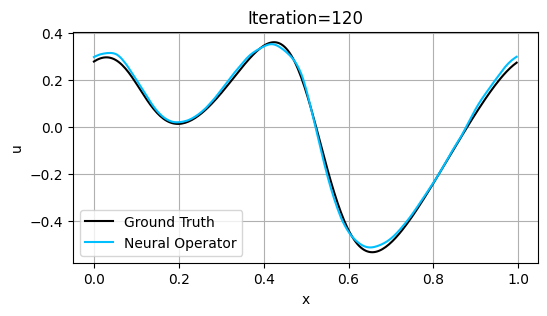

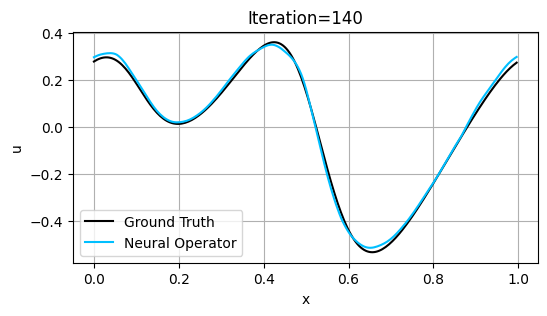

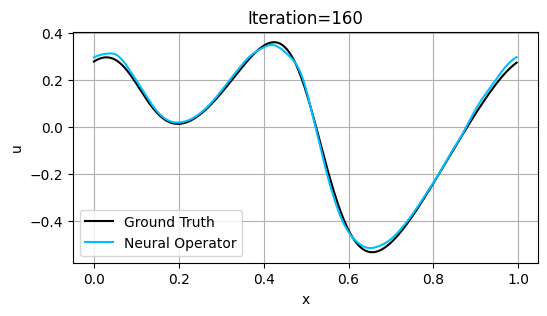

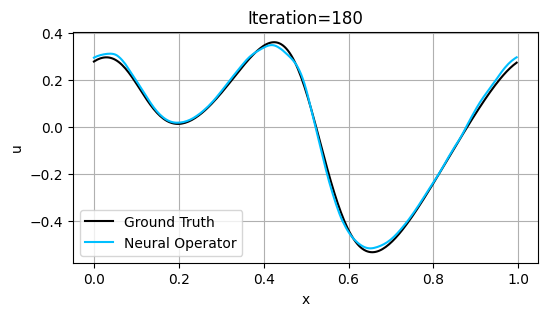

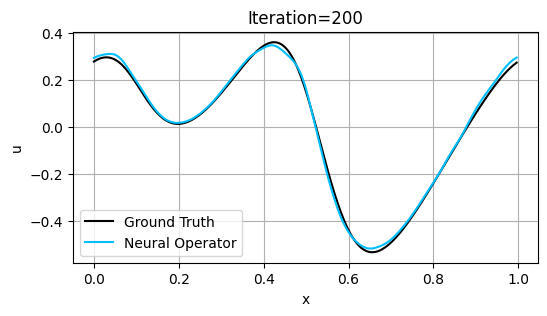

KeyboardInterrupt: 

In [21]:

    
    

model = FNO1d(width=64)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

files = []
import os
save_dir = 'results/neural_operators/1d_burger'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
   
MAX_ITER = 300
for iter in range(MAX_ITER):
    lr_scheduler.step()

    optimizer.zero_grad()
    prediction = model(train_data[:,:,:2])
    loss = torch.mean((train_data[:,:,2]-prediction)**2)

    loss.backward()
    optimizer.step()

    prediction = model(val_data[:,:,:2])
    val_loss = torch.mean((val_data[:,:,2] - prediction)**2)

    print(f"{iter+1}/{MAX_ITER} - loss: {loss.detach().numpy():.5f}, val: {val_loss.detach().numpy():.5f}", end='\r')
    
    # plot a validation result as training progresses
    if (iter+1) % 5 == 0: 
        idx = 0
        plt.figure(figsize=(6,3))
        plt.plot(val_data[idx,:,0], val_data[idx,:,2], color='black', label = "Ground Truth")
        plt.plot(val_data[idx,:,0], prediction[idx,:].detach(), color='deepskyblue', label = "Neural Operator")
        plt.grid()
        plt.xlabel("x")
        plt.ylabel("u")
        plt.title(f'Iteration={iter+1}')
        plt.legend()
        
        file = os.path.join(save_dir, "fno_%.6i.png"%(iter+1))
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (iter+1) % 20 == 0: plt.show()
        else: plt.close("all")

from PIL import Image
fps = 20
imgs = [Image.open(file) for file in files]
imgs[0].save(fp="results/neural_operators/FNO_1d_burger.gif", format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=True)

### References
- https://github.com/xiaoyuxie-vico/Sci-ML-Book/blob/main/FNO/FNO-1D/FNO-1D.ipynb